In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
num_classes = 10
labels_per_class = 16 # full
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline_augmented'
)
print(datestring)

cifar10_16____2020_08_09_22_43_34_001017_baseline_augmented


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build network

In [8]:
from tensorflow.keras import datasets, layers, models
from tensorflow_addons.layers import WeightNormalization

def conv_block(filts, name, kernel_size = (3, 3), padding = "same", **kwargs):
    return WeightNormalization(
        layers.Conv2D(
            filts, kernel_size, activation=None, padding=padding, **kwargs
        ),
        name="conv"+name,
    )
#CNN13
#See: 
#https://github.com/vikasverma1077/ICT/blob/master/networks/lenet.py
#https://github.com/brain-research/realistic-ssl-evaluation

In [9]:

lr_alpha = 0.1
dropout_rate = 0.5
num_classes = 10
input_shape = (32, 32, 3)
model = models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
### conv1a
name = '1a'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1b
name = '1b'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1c
name = '1c'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp1"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop1"))

### conv2a
name = '2a'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha))

### conv2b
name = '2b'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv2c
name = '2c'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp2"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop2"))

### conv3a
name = '3a'
model.add(conv_block(name = name, filts = 512, kernel_size = (3,3), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3b
name = '3b'
model.add(conv_block(name = name, filts = 256, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3c
name = '3c'
model.add(conv_block(name = name, filts = 128, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.AveragePooling2D(pool_size=(6, 6), strides=2, padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation=None, name='z'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
model.add(WeightNormalization(layers.Dense(num_classes, activation=None)))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1a (WeightNormalization) (None, 32, 32, 128)       7297      
_________________________________________________________________
bn1a (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1a (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1b (WeightNormalization) (None, 32, 32, 128)       295297    
_________________________________________________________________
bn1b (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1b (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1c (WeightNormalization) (None, 32, 32, 128)       2

### Augmentation

In [11]:
import tensorflow_addons as tfa
def augment(image, label):
    image = tf.squeeze(image) # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, dims[0] + 6, dims[1] + 6) # crop 6 pixels
    image = tf.image.random_crop(image, size=dims)
    image = tf.image.random_brightness(image, max_delta=0.15)  # Random brightness
    image= tf.image.random_contrast(image, lower=0.6, upper=1.4)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.05, seed=None)
    #image = tf.image.random_jpeg_quality(image, 10, 100, seed=None)
    image = tfa.image.rotate(image, tf.squeeze(tf.random.uniform(shape = (1,1), minval=-.2, maxval=.2)), interpolation='BILINEAR')
    image = tfa.image.random_cutout(tf.expand_dims(image, 0), (8,8), constant_values=0.5)[0]
    image = tf.clip_by_value(image, 0, 1)
    return image, label

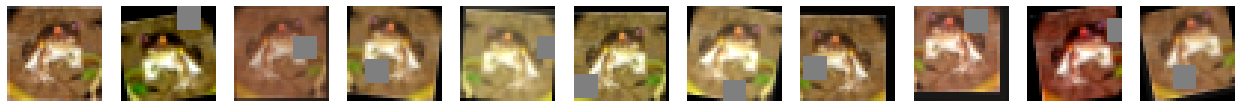

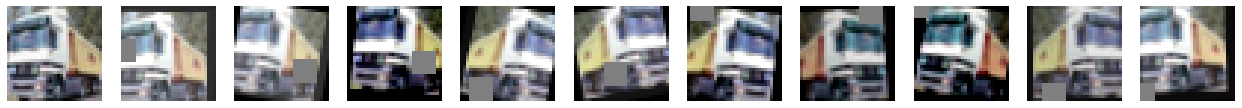

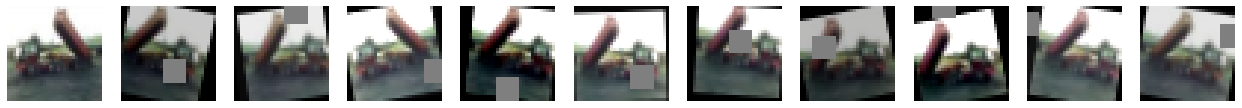

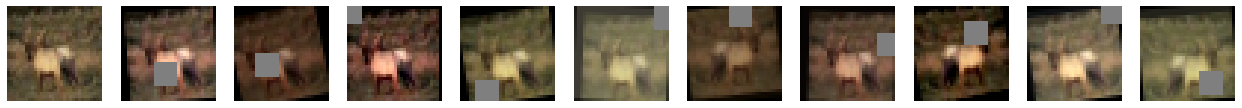

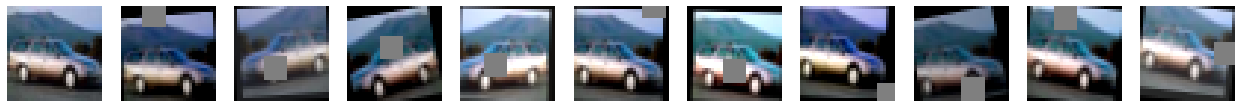

In [12]:
nex = 10
for i in range(5):
    fig, axs = plt.subplots(ncols=nex +1, figsize=((nex+1)*2, 2))
    axs[0].imshow(X_train[i])
    axs[0].axis('off')
    for ax in axs.flatten()[1:]:
        ax.imshow(augment(X_train[i], Y_train[i])[0])
        ax.axis('off')

### train

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=50, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [14]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)
model.compile(tf.keras.optimizers.Adam(1e-3), loss = loss, metrics=['accuracy'])

In [15]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [16]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [17]:
train_ds = (
     tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled_one_hot))
    .shuffle(1000)
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
) 

In [18]:
history = model.fit(
    train_ds,
    epochs=500,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping]
)

Epoch 1/500
2/2 [==============================] - 14s 7s/step - loss: 2.8283 - accuracy: 0.1063 - val_loss: 524.9704 - val_accuracy: 0.1003
Epoch 2/500
2/2 [==============================] - 9s 5s/step - loss: 4.0358 - accuracy: 0.1625 - val_loss: 348.0558 - val_accuracy: 0.0977
Epoch 3/500
2/2 [==============================] - 9s 4s/step - loss: 3.5795 - accuracy: 0.0625 - val_loss: 653.4223 - val_accuracy: 0.1006
Epoch 4/500
2/2 [==============================] - 9s 4s/step - loss: 3.1428 - accuracy: 0.1750 - val_loss: 1026.1368 - val_accuracy: 0.0952
Epoch 5/500
2/2 [==============================] - 9s 5s/step - loss: 2.6284 - accuracy: 0.1312 - val_loss: 1101.5769 - val_accuracy: 0.0952
Epoch 6/500
2/2 [==============================] - 7s 4s/step - loss: 2.5770 - accuracy: 0.1937 - val_loss: 766.6614 - val_accuracy: 0.1015
Epoch 7/500
2/2 [==============================] - 6s 3s/step - loss: 2.3894 - accuracy: 0.2125 - val_loss: 949.2670 - val_accuracy: 0.1014
Epoch 8/500
2/2 [

2/2 [==============================] - 10s 5s/step - loss: 1.6496 - accuracy: 0.5688 - val_loss: 6.4849 - val_accuracy: 0.1505
Epoch 60/500
2/2 [==============================] - 9s 5s/step - loss: 1.6643 - accuracy: 0.5375 - val_loss: 6.5702 - val_accuracy: 0.1479
Epoch 61/500
2/2 [==============================] - 10s 5s/step - loss: 1.6139 - accuracy: 0.5750 - val_loss: 6.6063 - val_accuracy: 0.1475
Epoch 62/500
2/2 [==============================] - 11s 6s/step - loss: 1.6313 - accuracy: 0.5938 - val_loss: 6.4908 - val_accuracy: 0.1538
Epoch 63/500
2/2 [==============================] - 9s 5s/step - loss: 1.6079 - accuracy: 0.6062 - val_loss: 6.1487 - val_accuracy: 0.1852
Epoch 64/500
2/2 [==============================] - 10s 5s/step - loss: 1.6094 - accuracy: 0.6000 - val_loss: 5.8347 - val_accuracy: 0.1878
Epoch 65/500
2/2 [==============================] - 9s 5s/step - loss: 1.6740 - accuracy: 0.5625 - val_loss: 6.5889 - val_accuracy: 0.1751
Epoch 66/500
2/2 [==================

Epoch 118/500
2/2 [==============================] - 4s 2s/step - loss: 1.3969 - accuracy: 0.7375 - val_loss: 3.4539 - val_accuracy: 0.2247
Epoch 119/500
2/2 [==============================] - 6s 3s/step - loss: 1.3567 - accuracy: 0.7812 - val_loss: 3.9297 - val_accuracy: 0.1988
Epoch 120/500
2/2 [==============================] - 9s 5s/step - loss: 1.3491 - accuracy: 0.7375 - val_loss: 4.4819 - val_accuracy: 0.1937
Epoch 121/500
2/2 [==============================] - 10s 5s/step - loss: 1.3438 - accuracy: 0.7750 - val_loss: 4.0400 - val_accuracy: 0.2227
Epoch 122/500
2/2 [==============================] - 10s 5s/step - loss: 1.3119 - accuracy: 0.7937 - val_loss: 3.6330 - val_accuracy: 0.2320
Epoch 123/500
2/2 [==============================] - 6s 3s/step - loss: 1.3977 - accuracy: 0.7625 - val_loss: 3.6706 - val_accuracy: 0.2022
Epoch 124/500
2/2 [==============================] - 9s 5s/step - loss: 1.2562 - accuracy: 0.8188 - val_loss: 4.0251 - val_accuracy: 0.1894
Epoch 125/500
2/2 

2/2 [==============================] - 7s 4s/step - loss: 1.0654 - accuracy: 0.9438 - val_loss: 2.6420 - val_accuracy: 0.3117
Epoch 177/500
2/2 [==============================] - 9s 4s/step - loss: 1.1117 - accuracy: 0.9187 - val_loss: 2.7863 - val_accuracy: 0.2742
Epoch 178/500
2/2 [==============================] - 8s 4s/step - loss: 1.0732 - accuracy: 0.9563 - val_loss: 2.8833 - val_accuracy: 0.2481
Epoch 179/500
2/2 [==============================] - 8s 4s/step - loss: 1.1043 - accuracy: 0.9250 - val_loss: 2.8954 - val_accuracy: 0.2726
Epoch 180/500
2/2 [==============================] - 7s 3s/step - loss: 1.1177 - accuracy: 0.8938 - val_loss: 2.9990 - val_accuracy: 0.2664
Epoch 181/500
2/2 [==============================] - 8s 4s/step - loss: 1.1056 - accuracy: 0.9250 - val_loss: 3.1267 - val_accuracy: 0.2565
Epoch 182/500
2/2 [==============================] - 9s 4s/step - loss: 1.1123 - accuracy: 0.9187 - val_loss: 3.0157 - val_accuracy: 0.2668
Epoch 183/500
2/2 [===============

### evaluate

In [19]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 6s 19ms/step - loss: 2.8446 - accuracy: 0.2964


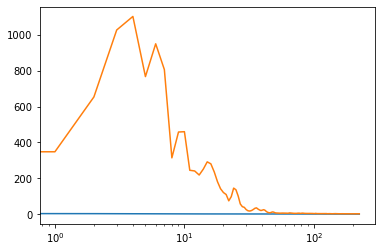

In [20]:
plt.semilogx(history.history['loss'])
plt.semilogx(history.history['val_loss'])

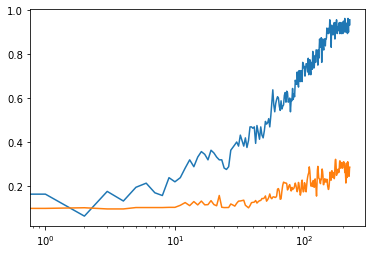

In [21]:
plt.semilogx(history.history['accuracy'])
plt.semilogx(history.history['val_accuracy'])

In [22]:
submodel = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
    )
z = submodel.predict(X_train)
np.shape(z)

(40000, 256)

In [23]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Aug  9 23:16:51 2020 Finding Nearest Neighbors
Sun Aug  9 23:16:51 2020 Building RP forest with 15 trees
Sun Aug  9 23:16:52 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Sun Aug  9 23:17:03 2020 Finished Nearest Neighbor Search
Sun Aug  9 23:17:06 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Aug  9 23:17:31 2020 Finished embedding


In [24]:
predictions = model.predict(X_train)

In [25]:
mask = np.array(np.argmax(predictions, axis=1)) != Y_train.flatten()

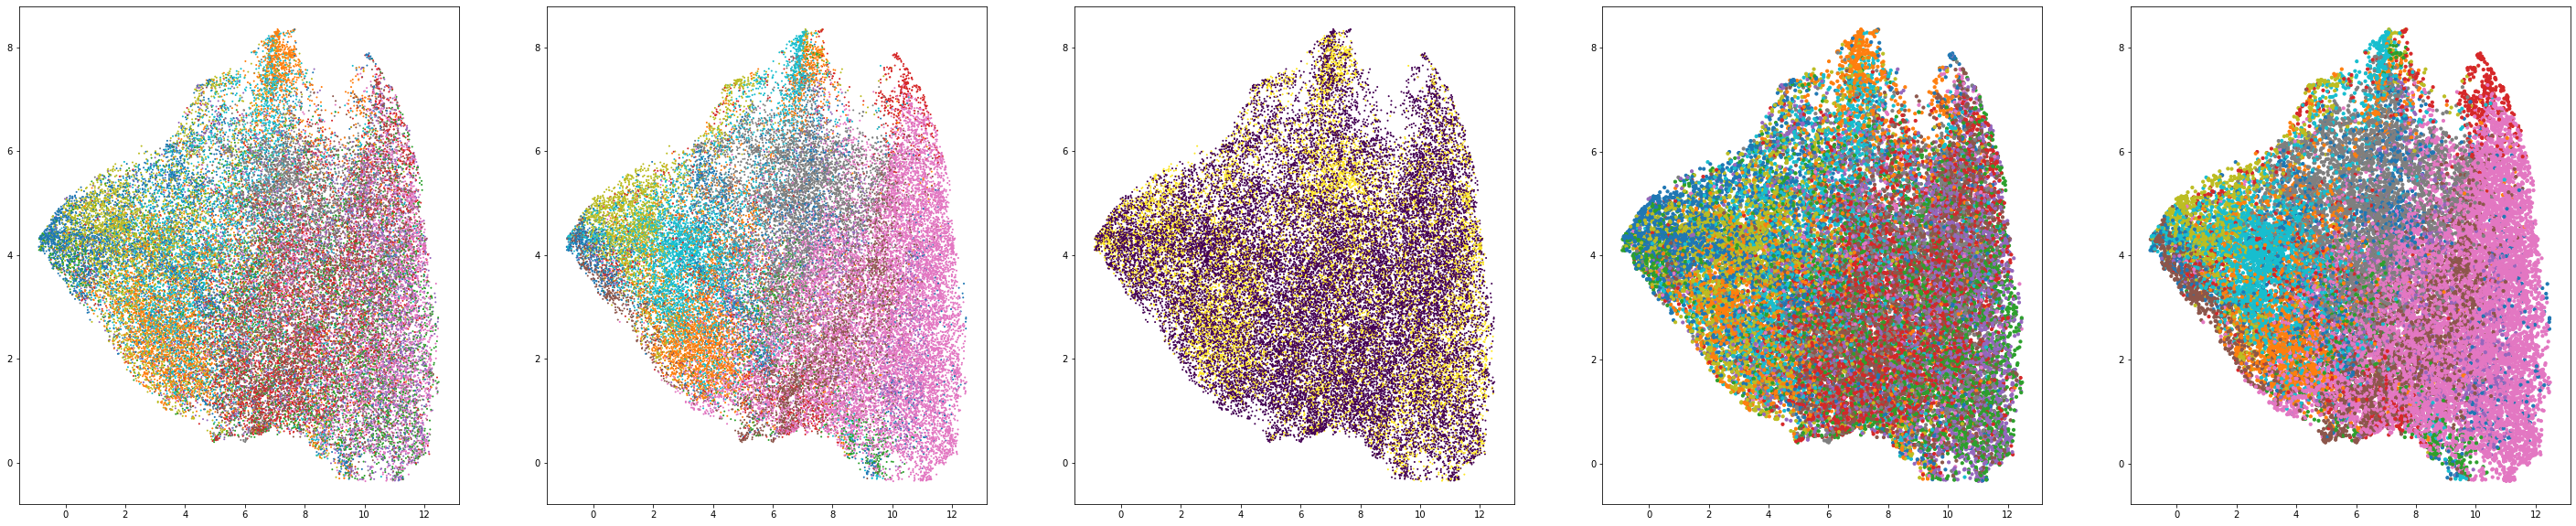

In [26]:
fig, axs = plt.subplots(ncols = 5, figsize=(50,10))
axs[0].scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 1, cmap = plt.cm.tab10)
axs[1].scatter(embedding[:, 0], embedding[:, 1], c=np.argmax(predictions, axis=1), s= 1, alpha = 1, cmap = plt.cm.tab10)
axs[2].scatter(embedding[:, 0], embedding[:, 1], c=np.array(np.argmax(predictions, axis=1)) == Y_train.flatten(), s= 1, alpha = 1, cmap = plt.cm.viridis)
axs[3].scatter(embedding[mask, 0], embedding[mask, 1], c=Y_train.flatten()[mask], s= 10, alpha = 1, cmap = plt.cm.tab10)
axs[4].scatter(embedding[mask, 0], embedding[mask, 1], c=np.argmax(predictions, axis=1)[mask], s= 10, alpha = 1, cmap = plt.cm.tab10)

### save results

In [27]:
# save score, valid embedding, weights, results

In [28]:
from tfumap.paths import MODEL_DIR, ensure_dir

In [29]:
save_folder = MODEL_DIR / 'semisupervised-keras' / dataset / str(labels_per_class) / datestring
ensure_dir(save_folder)

#### save weights

In [30]:
encoder = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
)

In [31]:
encoder.save_weights((save_folder / "encoder").as_posix())

In [32]:
classifier = tf.keras.models.Model(
        [tf.keras.Input(tensor=model.get_layer('weight_normalization').input)], [model.outputs[0]]
)
print([i.name for i in classifier.layers])

['input_2', 'weight_normalization', 'lrelufc1', 'weight_normalization_1', 'lrelufc2', 'weight_normalization_2']


In [33]:
classifier.save_weights((save_folder / "classifier").as_posix())

In [41]:
model.save_weights((save_folder / "full_model").as_posix())

#### save score

In [34]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 3s 9ms/step - loss: 2.8446 - accuracy: 0.2964


In [35]:
np.save(save_folder / 'test_loss.npy', result)

#### save embedding

In [36]:
z = encoder.predict(X_train)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Mon Aug 10 09:31:29 2020 Finding Nearest Neighbors
Mon Aug 10 09:31:29 2020 Building RP forest with 15 trees
Mon Aug 10 09:31:30 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Mon Aug 10 09:31:32 2020 Finished Nearest Neighbor Search
Mon Aug 10 09:31:32 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Aug 10 09:32:16 2020 Finished embedding


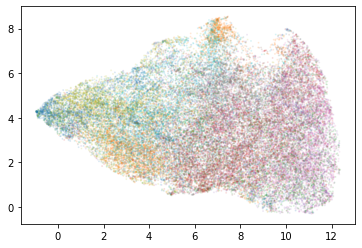

In [37]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [38]:
np.save(save_folder / 'train_embedding.npy', embedding)

#### save results

In [39]:
import pickle

In [40]:
with open(save_folder / 'history.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)